## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II


# Red neuronal multi-capa

## Actividad 4

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

En este cuadernos estudiaremos algunos conceptos claves del aprendizaje profundo, y construiremos paso a paso una red densamente conectada con múltiples capas escondidas. Implementaremos la red profunda repasando conceptos de optmización e inicialización de pesos. Finalmente probaremos nuestra red para el tratamiento de imagenes e intentar mejorar los resultados que obtuvimos con nuestra red sencilla para la detección automática de frailejones sore imagenes aereas del páramo. 

Estas actividades para la construcción de redes neuronales desde cero se han basado en:
http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/


### Nombres:

#### Angie Paola Chacón -201012536
#### Juan Sebastian Rincón -201214767
#### Carolina Padilla Hernández -201111402

## Introducción

Previamente hemos entrenado una red neuronal sencilla de dos capas (con una capa escondida y una capa de salida). Ahora vamos a construir una red profunda, con múltiples capas escondidas. Primero vamos a implementar las funciones requeridas para construir una red neuronal profunda. 

Utilizaremos unidades no-lineales mediante una función como la *Rectified Linear Unit* (ReLU), la cual permite disminuir los tiempos de entrenamiento de una red compleja. Implementaremos diferentes técnicas de inicialización de parámetros, como la incialización de *Xavier* o de *He* (K. He, X. Zhang, Sh. Ren, J.Sun. Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification. Proceedings IEEE International Conference on Computer Vision (ICCV), 2015, 1026-1034).

Finalmente implementaremos nuestro código para clasificación de imagenes aereas del paramo y la detección automática de plantas nativas.

Para la construcción de la red, denotaremos por el superíndice $[l]$ a los parámetros de la *l-ésima* capa. Por ejemplo, $a^{[l]}$ corresponderá con la activación de la *l-ésima* capa, y $W^{[l]}$ y $b^{[l]}$ serán los parámetros de la *l-ésima* capa.

El superíndice $(i)$ denota una cantidad asociada con el *i-ésimo* ejemplo. Así, $x^{(i)}$ será el *i-ésimo* ejemplo de entrenamiento. Y el subíndice $i$ denota la *i-ésima* entrada de un vector. De esta manera $a^{[l]}_i$ denota la *i-ésima* entrada de las activaciones de la *l-ésima* capa.

Importemos algunos de los paquetes que vamos a utilizar:


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from ImportImagenes_L import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # se fija el tamaño de los gráficos
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


Para construir la red neuronal, primero se construirán funciones auxiliares que permitirán implementar una red neuronal de L capas. Primero estudiaremos la incializacion de los parametros para una red de $L$ capas, e implementaremos la propagación hacia delante.

La arquitectura de la red consistirá en capas densamente conectadas que propagan hacia delante el mensaje LINEAL de las capas anteriores, obteniendo $Z^{[l]}$, y activandose mediante una función de ACTIVACION, **RELU** o **SIGMOIDE**. 

De esta manera, se combinan los pasos [LINEAL->ACTIVACION] en una sola función (hacia delante), y tras ello, se agrupan las funciones de propagación hacia delante [LINEAL->RELU] L-1 veces (para las capas 1 hasta L-1). Finalmente se añade la capa de salida [LINEAL->SIGMOIDE] para la última capa $L$. Esta agrupacion la tendremos en la función ``propaga_L``.

A cada función de propagación hacia delante le corresponde una función hacia atrás. Por ello, a cada paso hacia delante, guardaremos algunos valores necesarios para calcular los gradientes.

Luego compytaremos la pérdida e implmentaremos la retro-propagación. Completaremos la parte LINEAL de la retro-propagación de una capa, a partir del gradiente de la función de activación, y combinaremos los pasos en una nueva función de retro-propagación [LINEAL->ACTIVACION]. Agruparemos las funciones de retro-propagación [LINEAL->RELU] L-1 veces y añadiremos la correspondiente [LINEAL->SIGMOIDE] en una nueva función ``retro_L``.

Por último, actualizaremos los parámetros para implementar el bucle de aprendizaje de la red y ajustar el modelo de red con los datos que nos sean proporcionados.


*Lectura opcional sobre funciones de activación tipo SELU: https://towardsdatascience.com/gentle-introduction-to-selus-b19943068cd9*


## 1. Inicialización de parámetros

Entrenar una red neuronal requiere especificar unos valores iniciales para los pesos. Un método de inicialización bien elegido va a mejorar bastante el aprendizaje. La inicialización de una red neuronal profunda es más compleja que la de una red sencilla, pues contamos con una mayor número de parámetros (hay más matrices de pesos y vectores de sesgo).   

Un método de inicialización bien elegido permite:
- Incrementar la velocidad de convergencia de la búsqueda por los parámetros (mediante GD) 
- Incrementar las probabilidades de que el método de búsqueda (GD) converja hacia un error de entrenamiento menor, y una mejor generalización  

La incialización la implementaremos mediante la fucnión `param_I_L`.

Recuerde asegurarse que las dimensiones de las matrices con los parametros sean coherentes al pasar de capa en capa. Recuerde que  $n^{[l]}$ es el número de unidades en la capa $l$. Entonces, e.g., si el tamaño de la entrada $X$ es $(14700, 175)$ (con $m=175$ ejemplos), se tiene que:


<table style="width:100%">
    <tr>
        <td>       </td> 
        <td> **Dimensión de W**     </td> 
        <td> **Dimensión de b**   </td> 
        <td> **Activación**</td>
        <td> **Dimensión de la activación**  </td> 
    </tr>
    <tr>
        <td> **Capa 1** </td> 
        <td> $(n^{[1]},14700)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},175)$ </td> 
    </tr>
    <tr>
        <td> **Capa 2** </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 175)$ </td> 
    </tr>
    <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
    </tr>
    <tr>
        <td> **Capa L-1** </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 175)$ </td> 
    </tr>
    <tr>
        <td> **Capa L** </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 175)$  </td> 
    </tr>
</table>

## Ejercicio 1.1

Implemente la inicialización de una red neuronal con L capas. 

Tenga en cuenta que:
- Inicializaciones diferentes llevan a resultados distintos
- En redes complejas, si los pesos son inicializados muy pequeñas o muy grandes, podemos encontrarnos con el problema de gradientes que se desvanecen o que explotan.
- La incialización aleatoria es usada para romper la simetría y asegurarse que las distintas unidades escondidas (neuronas) puedan aprender funciones distintas

Recuerde que la estructura del modelo es [LINEAL -> RELU] $ \times$ (L-1) -> LINEAL -> SIGMOIDE. Esto es, la red tiene $L-1$ capas utilizando una función de activación ReLU, seguido de una capa de salida con la función de activación Sigmoide.

i) Implemente una inicialización aleatoria para las matrices de pesos. 
Para ello utilice `np.random.randn(shape) * 0.01`.

Para los sesgos, utilize una inicialización de ceros. 
Para ello utilice `np.zeros(shape)`.

ii) Implemente la inicialización de Xavier y de He. El método de He fue presentado en el paper publicado por He et al., 2015. Es muy similar a la inicialización de Xavier, sólo que en la de Xavier los pesos  $W^{[l]}$ se multiplican por `sqrt(1./dim_capas[l])`, mientras que en la de He se multiplican por `sqrt(2./dim_capas[l])`.)

*Nota:* la inicialización de He se recomienda para las capas con una activación ReLU. 


El número de unidades en cada capa $n^{[l]}$, se guarda en la variable `dim_capas`. De esta manera, por ejemplo, las `dim_capas` con 2 dimensiones de entrada, una capa escondida con 4 unidades, y una capa de salida con una unidad, corresponde con [2,4,1]. Por lo tanto, la forma de `W1` sería de (4,2), la de `b1` (4,1), `W2` (1,4) y `b2` (1,1). 


*Ayuda:* La implementación para $L=1$ sería de la siguiente manera:
```python
    if L == 1:
        param["W" + str(L)] = np.random.randn(dim_capas[1], dim_capas[0]) * 0.01
        param["b" + str(L)] = np.zeros((dim_capas[1], 1))
```

In [2]:
def param_I_L(dim_capas, init, semilla): #inicialización de parámetros
    """
    Input:
    dim_capas: arreglo (lista) de python con las dimensiones de cada capa de la red
    init: método de incialización "rand", "Xav, "He"
    semilla: la semilla aleatoria para la incializacion
    Output:
    param: diccionario python con los parametros "W1", "b1", ..., "WL", "bL":
                    Wl: matriz de pesos (dim_capas[l], dim_capas[l-1])
                    bl: vector de sesgo (dim_capas[l], 1)
    """
    
    np.random.seed( semilla )
    param = {}
    L = len(dim_capas)           

    for l in range(1, L):
        
        if init == "rand":
        # Inicializacion aleatoria
            param['W' + str(l)] = np.random.randn(dim_capas[l], dim_capas[l-1]) * 0.01
            param['b' + str(l)] = np.zeros((dim_capas[l], 1))
        
        # Inicializacion de Xavier
        #Inicializacion de He
        elif init == "Xav":
            param['W' + str(l)] =  np.random.randn(dim_capas[l], dim_capas[l-1]) * np.sqrt(1./dim_capas[l])
            param['b' + str(l)] = np.zeros((dim_capas[l], 1))
            
        #Inicializacion de He
        elif init == "He":
            param['W' + str(l)] = np.random.randn(dim_capas[l], dim_capas[l-1]) * np.sqrt(2./dim_capas[l])
            param['b' + str(l)] = np.zeros((dim_capas[l], 1))
            
        
        assert(param['W' + str(l)].shape == (dim_capas[l], dim_capas[l-1]))
        assert(param['b' + str(l)].shape == (dim_capas[l], 1))

        
    return param

In [3]:
param = param_I_L([5,4,3], "rand", 9)
print("Inicializacion aleatoria:")
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

Inicializacion aleatoria:
W1 = [[ 1.10855471e-05 -2.89544069e-03 -1.11606630e-02 -1.28827567e-04
  -3.78361464e-03]
 [-4.81135363e-03 -1.51733118e-02 -4.90871981e-03 -2.40680579e-03
  -6.47947460e-03]
 [ 6.35891080e-03  1.74011731e-02  2.96682218e-03  7.07503662e-03
   1.82281576e-02]
 [ 4.30769029e-03  1.54272963e-02 -9.00721171e-03 -1.37125010e-03
   1.29757901e-02]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.00675271  0.00031958  0.00918146  0.00380509]
 [ 0.00516367 -0.00355239  0.00208777  0.00328411]
 [-0.00498225 -0.02091777 -0.00082588  0.02455183]]
b2 = [[0.]
 [0.]
 [0.]]


**Salida esperada**:
       
Inicializacion aleatoria:
<table style="width:80%">
  <tr>
    <td> W1 </td>
    <td>[[ 1.10855471e-05 -2.89544069e-03 -1.11606630e-02 -1.28827567e-04
  -3.78361464e-03]
 [-4.81135363e-03 -1.51733118e-02 -4.90871981e-03 -2.40680579e-03
  -6.47947460e-03]
 [ 6.35891080e-03  1.74011731e-02  2.96682218e-03  7.07503662e-03
   1.82281576e-02]
 [ 4.30769029e-03  1.54272963e-02 -9.00721171e-03 -1.37125010e-03
   1.29757901e-02]]</td> 
  </tr>
  <tr>
    <td>b1 </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  <tr>
    <td>W2 </td>
    <td>[[ 0.00675271  0.00031958  0.00918146  0.00380509]
 [ 0.00516367 -0.00355239  0.00208777  0.00328411]
 [-0.00498225 -0.02091777 -0.00082588  0.02455183]]</td> 
  </tr>
  <tr>
    <td>b2 </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

In [4]:
param = param_I_L([5,4,3], "Xav", 9)
print("Inicializacion de Xavier:")
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

Inicializacion de Xavier:
W1 = [[ 5.54277356e-04 -1.44772035e-01 -5.58033152e-01 -6.44137837e-03
  -1.89180732e-01]
 [-2.40567681e-01 -7.58665589e-01 -2.45435991e-01 -1.20340289e-01
  -3.23973730e-01]
 [ 3.17945540e-01  8.70058653e-01  1.48341109e-01  3.53751831e-01
   9.11407882e-01]
 [ 2.15384515e-01  7.71364813e-01 -4.50360586e-01 -6.85625052e-02
   6.48789506e-01]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.38986799  0.01845103  0.53009178  0.21968724]
 [ 0.29812491 -0.2050976   0.12053746  0.18960822]
 [-0.2876502  -1.20768788 -0.04768205  1.41750037]]
b2 = [[0.]
 [0.]
 [0.]]


**Salida esperada**:

Inicializacion de Xavier:
<table style="width:80%">
  <tr>
    <td> **W1** </td>
    <td>[[ 5.54277356e-04 -1.44772035e-01 -5.58033152e-01 -6.44137837e-03
  -1.89180732e-01]
 [-2.40567681e-01 -7.58665589e-01 -2.45435991e-01 -1.20340289e-01
  -3.23973730e-01]
 [ 3.17945540e-01  8.70058653e-01  1.48341109e-01  3.53751831e-01
   9.11407882e-01]
 [ 2.15384515e-01  7.71364813e-01 -4.50360586e-01 -6.85625052e-02
   6.48789506e-01]]</td> 
  </tr>
  
  <tr>
    <td>**b1** </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
  <tr>
    <td>**W2** </td>
    <td>[[ 0.38986799  0.01845103  0.53009178  0.21968724]
 [ 0.29812491 -0.2050976   0.12053746  0.18960822]
 [-0.2876502  -1.20768788 -0.04768205  1.41750037]]</td> 
  </tr>
  
  <tr>
    <td>**b2** </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

In [5]:
param = param_I_L([5,4,3], "He", 9)
print("Inicializacion de He:")
print("W1 = " + str(param["W1"]))
print("b1 = " + str(param["b1"]))
print("W2 = " + str(param["W2"]))
print("b2 = " + str(param["b2"]))

Inicializacion de He:
W1 = [[ 7.83866554e-04 -2.04738575e-01 -7.89178051e-01 -9.10948466e-03
  -2.67541957e-01]
 [-3.40214078e-01 -1.07291517e+00 -3.47098907e-01 -1.70186869e-01
  -4.58168043e-01]
 [ 4.49642895e-01  1.23044875e+00  2.09786008e-01  5.00280637e-01
   1.28892539e+00]
 [ 3.04599702e-01  1.09087458e+00 -6.36906048e-01 -9.69620247e-02
   9.17526919e-01]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.5513566   0.02609369  0.74966299  0.31068468]
 [ 0.42161229 -0.2900518   0.17046571  0.26814652]
 [-0.40679882 -1.70792858 -0.06743261  2.00464824]]
b2 = [[0.]
 [0.]
 [0.]]


**Salida esperada**:

Inicializacion de He:
<table style="width:80%">
  <tr>
    <td> W1 </td>
    <td>[[ 7.83866554e-04 -2.04738575e-01 -7.89178051e-01 -9.10948466e-03
  -2.67541957e-01]
 [-3.40214078e-01 -1.07291517e+00 -3.47098907e-01 -1.70186869e-01
  -4.58168043e-01]
 [ 4.49642895e-01  1.23044875e+00  2.09786008e-01  5.00280637e-01
   1.28892539e+00]
 [ 3.04599702e-01  1.09087458e+00 -6.36906048e-01 -9.69620247e-02
   9.17526919e-01]]</td> 
  </tr>
  <tr>
    <td>b1 </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  <tr>
    <td>W2 </td>
    <td>[[ 0.5513566   0.02609369  0.74966299  0.31068468]
 [ 0.42161229 -0.2900518   0.17046571  0.26814652]
 [-0.40679882 -1.70792858 -0.06743261  2.00464824]]</td> 
  </tr>
  <tr>
    <td>b2 </td>
    <td>[[ 0.]
 [ 0.]
 [ 0.]]</td> 
  </tr>
  
</table>

## 2. Propagación hacia delante

Una vez inicializados los parámetros, debemos implementar la propagación hacia delante. Vamos a empezar por implementar algunas funciones básicas para ser utilizadas más adelante en la implementación del modelo. 

Vamos a implementar 3 funciones:
- LINEAL
- LINEAL -> ACTIVACION donde la activación será ReLU o Sigmoide. 
- [LINEAL -> RELU] $\times$ (L-1) -> LINEAL -> SIGMOIDE (modelo completo)

Esta implementación (vectorizada) de la propagación hacia delante calcula las siguientes ecuaciones:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$

donde $A^{[0]} = X$. 

### Ejercicio 2.1 
Construya la parte LINEAL de la propagación hacia delante. 

*Ayuda:* Puede ser útil la función`np.dot()`. También, si las dimensiones no casan, puede investigar lo que ocurre llamando a `W.shape`.

In [6]:
def lineal(A, W, b):
    """
    Implemente la parte lineal para la propagación hacia delante de una capa
    Input:
    A: las activaciones de la capa previa (o los datos de entrada): (tamaño de la capa previa, número de ejemplos)
    W: matriz de pesos, un arreglo numpy de dimensiones (tamaño de la capa actual, tamaño de la capa previa)
    b: vector de sesgo, un arreglo numpy de dimensiones (tamaño de la capa actual, 1)
    Output:
    Z: la entrada para la función de activación, también llamado parámetro de pre-activación 
    memo: diccionario python con "A", "W" y "b", almacenados para computar los pasos hacia atrás de manera eficiente
    """
    
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    memo = (A, W, b)
    
    return Z, memo

In [7]:
np.random.seed(9)
A = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)

Z, memo = lineal(A, W, b)
print("Z = " + str(Z))

Z = [[-0.01071957 -0.08648949]]


**Salida esperada**:

<table style="width:35%"> 
  <tr>
    <td> Z </td>
    <td> [[-0.01071957 -0.08648949]] </td> 
  </tr>
  
</table>

### Activación lineal

Ahora construyamos la *activación-lineal hacia delante*. Para ello, necesitamos las dos funciones de activación:

- **Sigmoide**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. Esta función `sigmoide` devuelve 2 objetos: el valor de activación "`a`" y una memoria "`memo`" que contiene "`Z`" (la cual se le pasa a la correspondiente función de retro-propagación). 

Para usarla basta con este comando: 
``` python
A, memo = sigmoide(Z)
```


In [8]:
def sigmoide(Z):
    
    A = 1/(1+np.exp(-Z))
    memo = Z
    
    return A, memo


- **ReLU**:  $A = RELU(Z) = max(0, Z)$. Esta función `relu` también devuelve 2 objetos: el valor de activación "`a`" y una "`memo`" que contiene "`Z`" (la cual se le pasa a la correspondiente función de retro-propagación). 

Para usarla basta con este comando: 
``` python
A, memo = relu(Z)
```

In [9]:
def relu(Z):
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    memo = Z 
    return A, memo


Para mayor conveniencia, vamos a agrupar dos funciones (Lineal y Activacion) en una sola (LINEAL->ACTIVACION). Por lo tanto, vamos a implementar una función que da el paso LINEAL hacia delante seguido del paso de ACTIVACION hacia delante.

### Ejercicio 2.2  

Implemente la propagación hacia delante de la capa *LINEAL->ACTIVACION*. La ecuación matemática es: $$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$$ donde la activación "g" puede ser sigmoide() o relu(). Utilice la función que acabamos de escribir `lineal()` y la función de activación correcta.

In [10]:
def activacion_lineal(A_prev, W, b, activacion): #Propagación hacia adelante 
    """
    Implementa la activación lineal para una capa LINEAL->ACTIVACION
    Input:
    A_prev: activaciones de la capa previa: (tamaño de la capa previa, número de ejemplos)
    W: matriz de pesos, un arreglo numpy de dimensiones (tamaño de la capa actual, tamaño de la capa previa)
    b: vector de sesgo, un arreglo numpy de dimensiones (tamaño de la capa actual, 1)
    activacion: la activación a ser usada en la capa, guardada como una cadena de texto: "sigmoide" or "relu"
    Output:
    A: la salida de la función de activación, también llamada valor de post-activacion 
    memo: dicionario python con la "memo_lineal" y la "memo_activacion"
    """
    
    if (activacion == "sigmoide"):
        # Inputs: "A_prev, W, b". Outputs: "A, memo_activacion"
        Z, memo_lineal = lineal(A_prev, W,b)
        A, memo_activacion = sigmoide(Z)
    
    elif (activacion == "relu"):
        # Inputs: "A_prev, W, b". Outputs: "A, memo_activacion".
        Z, memo_lineal = lineal(A_prev,W,b)
        A, memo_activacion = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    memo = (memo_lineal, memo_activacion)

    return A, memo


In [11]:
np.random.seed(99)
A_prev = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)

A, activacion_lineal_memo = activacion_lineal(A_prev, W, b, activacion="sigmoide")
print("Con sigmoide: A = " + str(A))

A, activacion_lineal_memo = activacion_lineal(A_prev, W, b, activacion="relu")
print("Con ReLU: A = " + str(A))

Con sigmoide: A = [[0.09761704 0.57236238]]
Con ReLU: A = [[0.         0.29149618]]


**Salida esperada**:
       
<table style="width:35%">
  <tr>
    <td> Con sigmoide: A  </td>
    <td > [[0.09761704 0.57236238]] </td> 
  </tr>
  <tr>
    <td> Con ReLU: A </td>
    <td > [[0.         0.29149618]] </td> 
  </tr>
</table>


## Modelo con L capas 

Con el fin de facilitar la implementación de la red neuronal de $L$ capas  necesitamos una función que replique la propagación hacia delante (`activacion_lineal`) con RELU, $L-1$ veces, seguida por la función (`activacion_lineal`) con la función SIGMOIDE.


### Ejercicio 2.3
Implemente la propagación hacia delante del modelo completo.

Tenga en cuenta que en el código la variable `AL` denota la estimación de la última capa de salida $$A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$$ 

Utilice las funciones que ha programado antes, recuerde usar un bucle for para replicar la [LINEAL->RELU] (L-1) veces y no olvide ir guardando las salidas de cada capa en la lista "memos". 

*Ayuda:* Para ir guardando los valores de `c`en una lista use `list.append(c)`.

In [12]:
def propagacion_L(X, param):
    """
    Implemente la propagación hacia delante para calcular [LINEAL->RELU]*(L-1)->LINEAL->SIGMOIDE
    Input:
    X: datos de entrada, arreglo de tamaño (tamaño del input, número de ejemplos)
    param: parametros que se obtienen de la inicializacion param_I_L()
    Output:
    AL: último valor de post-activación
    memos: lista de memos con cada memo de activacion_lineal() (hay L-1 memos, indexadas de 0 a L-1)
    """

    memos = []
    A = X
    L = len(param) // 2                  # número de capas en la red neuronal
    
    # Implemente [LINEAL -> RELU]*(L-1). Añada "memo" a la lista de "memos".
    for l in range(1, L):
        A_prev = A 
        A, memo = activacion_lineal(A_prev, param['W' + str(l)],  param['b' + str(l)], activacion= 'relu')
        memos.append(memo)

    
    # Implemente LINEAL -> SIGMOIDE. Añada "memo" a la lista de "memos".
    AL, memo = activacion_lineal(A, param['W' + str(L)],  param['b' + str(L)], activacion='sigmoide')
    memos.append(memo)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, memos

In [13]:
np.random.seed(55)

X = np.random.randn(4,2)
W1 = np.random.randn(3,4)
b1 = np.random.randn(3,1)
W2 = np.random.randn(1,3)
b2 = np.random.randn(1,1)

params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
AL, memos = propagacion_L(X, params)
print("AL = " + str(AL))
print("Longitud de la lista de memos = " + str(len(memos)))

AL = [[0.40900153 0.40900153]]
Longitud de la lista de memos = 2


**Salida esperada**:

<table style="width:50%">
  <tr>
    <td> AL </td>
    <td > [[0.40900153 0.40900153]]</td> 
  </tr>
  <tr>
    <td> Longitud de la lista de memos  </td>
    <td > 2 </td> 
  </tr>
</table>

Muy bien, llegado a este punto ya tenemos listo todo el proceso de propagación hacia delante. Este proceso toma la entrada X y obtiene como salida el vector-fila $A^{[L]}$ de predicciones. Y hemos guardado los valores intermedios en "`memos`". A partir de aquí podemos calcular el coste o pérdida de las predicciones.

## 3. Función de pérdida o coste

Ahora, con el fin de implementar la propagación hacia delante y hacia atrás, debemos computar el coste con el fin de verificar si el modelo en verdad está aprendiendo.

### Ejercicio 3.1
Calcule el coste por entropía-cruzada $J$, en base a la siguiente fórmula: $$J=-\frac{1}{m} \sum\limits_{i = 1}^{m} \biggr( y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \biggl) $$


In [14]:
def perdida_L(AL, Y): #Función de costo 
    """
    Implementa la función de coste por entropía cruzada.
    Input:
    AL: vector con las probabilidades para las etiquetas de predicción, dimensiones (1, número de ejemplos)
    Y: vector de etiquetas observadas, de dimensión (1, número de ejemplos)
    Output:
    coste: coste de entropía cruzada
    """
    
    m = Y.shape[1]

    # Compute la pérdida de AL e Y.
    logprobs = np.multiply(Y,np.log(AL)) + np.multiply(1-Y,np.log(1-AL))
    coste = -1/m * np.sum(logprobs)
    
    coste = np.squeeze(coste)      # Para asegurar que la dimensión de se coste es correcta (e.g. [[17]] se torna en 17).
    assert(coste.shape == ())
    
    return coste


In [15]:
Y = np.asarray([[1, 0, 1]])
AL = np.array([[.8,.5,0.95]])

print("coste = " + str(perdida_L(AL, Y)))

coste = 0.32252800875390186


**Salida esperada**:

<table>
    <tr>
    <td>coste </td>
    <td> 0.32252800875390186 </td> 
    </tr>
</table>

## 4. Retro-propagación

Como en el caso de la propagación hacia delante, vamos a implementar funciones auxiliares para la retro-propagación. Recuerde que la retro-propagación permite calcular el gradiente de la función de coste con respecto a los parámetros. 

Análogamente a la propagación hacia delante, la retro-propagación se va a construir en tres pasos:
- LINEAL hacia atrás
- LINEAL -> ACTIVACION hacia atrás, donde ACTIVACION calcula la derivada de la función de activación (ReLU o sigmoide)
- [LINEAL -> RELU] $\times$ (L-1) -> LINEAL -> SIGMOIDE hacia atrás (modelo completo)



La retro-propagación, o propagación lineal hacia atrás para la capa $l$, se calcula a partir de la derivada $$dZ^{[l]} = \frac{\partial J }{\partial Z^{[l]}}$$. 

Ahora queremos obtener $(dW^{[l]}, db^{[l]} dA^{[l-1]})$ para poder actualizar nuestros parametros. Estos tres gradientes $(dW^{[l]}, db^{[l]}, dA^{[l]})$ se calculan a partir de $dZ^{[l]}$. 

Estas son la fórmulas que se necesitan:
$$ dW^{[l]} = \frac{\partial J }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial J }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial J }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$


### Ejercicio 4.1

Utilice las tres fórmulas (arriba) para implementar `retro_lineal()`.

In [16]:
def retro_lineal(dZ, memo): #retropopagación 
    """
    Implementa la parte lineal de la retro-propagación para una sola capa [l]
    Input:
    dZ: Gradiente del coste con respecto al output lineal de la capa actual
    memo: conjunto de valores (A_prev, W, b) provenientes de la propagación hacia delante en la capa actual
    Output:
    dA_prev: Gradiente del coste con respecto a la activación (de la capa previa: l-1), del mismo tamaño como A_prev
    dW: Gradiente del coste con respecto a W (de la capa actual: l), del mismo tamaño que W
    db: Gradiente del coste con respecto a b (de la capa actual: l), del mismo tamaño que b
    """
    A_prev, W, b = memo
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)                        #axis=1,keepdims=True
    dA_prev = np.dot(memo[1].T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [17]:
np.random.seed(43)
dZ = np.random.randn(1,2)
A = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
activacion_lineal_memo = (A, W, b)

dA_prev, dW, db = retro_lineal(dZ, activacion_lineal_memo)
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

dA_prev = [[ 0.32506047 -1.14728627]
 [-0.11305387  0.39901854]
 [-0.08917309  0.31473239]]
dW = [[ 0.19426711  0.29803996 -0.84899749]]
db = [[-0.32554075]]


**Salida esperada**:

<table style="width:90%">
    <tr>
      <td> dA_prev </td>
      <td > [[ 0.32506047 -1.14728627]
 [-0.11305387  0.39901854]
 [-0.08917309  0.31473239]] </td> 
    </tr> 
    <tr>
        <td> dW </td>
        <td > [[ 0.19426711  0.29803996 -0.84899749]] </td> 
    </tr> 
    <tr>
        <td> db </td>
        <td> [[-0.32554075]] </td> 
    </tr> 
    
</table>



## Activación-lineal hacia atrás

A continuación, vamos a escribir una función que da el paso hacia atrás de la activación **`retro_activacion_lineal`**. 

Para implementar `retro_activacion_lineal`, necesitamos calcular las derivadas de la funcion sigmoide:
- **`sigmoide_retro`**, tal que 

```python
dZ = sigmoide_retro(dA, memo_activacion)
```


In [18]:
def sigmoide_retro(dA, memo):
    
    Z = memo
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

y la derivada de la funcion ReLU:
- **`relu_retro`**, de forma que 

```python
dZ = relu_retro(dA, memo_activacion)
```


In [19]:
def relu_retro(dA, memo):
    
    Z = memo
    dZ = np.array(dA, copy=True) 
    
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

Ahora vamos a implementar una función que da el paso LINEAL hacia atrás seguido del paso de ACTIVACION hacia atrás, todo en una misma capa *RETRO(LINEAL->ACTIVACION)*.

### Ejercicio 4.2

Si $g(.)$ es la función de activación, entonces 
`sigmoide_retro` y `relu_retro` calculan $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}) $$  

In [20]:
def retro_activacion_lineal(dA, memo, activacion):
    """
    Implementa la retro-propagación para la capa LINEAL->ACTIVACION .
    Input:
    dA: gradiente post-activacion para la capa actual l 
    memo: conjunto de valores (linear_cache, activation_cache) que se guardan para calcular la retro-propagación de manera eficiente
    activacion: la activación a ser usada en esta capa, guardada como un arreglo de texto: "sigmoid" o "relu"
    Output:
    dA_prev: gradiente del coste con respecto a la activación (de la capa previa l-1), de las mismas dimensiones que A_prev
    dW: gradiente del coste con respecto a W (capa actual l), mismas dimensiones que W
    db: gradiente del coste con respecto a b (capa actual l), mismas dimensiones que b
    """
    memo_lineal, memo_activacion = memo
    
    if activacion == "relu":
        dZ = relu_retro(dA, memo_activacion)
        dA_prev, dW, db = retro_lineal(dZ, memo_lineal)
        
    elif activacion == "sigmoide":
        dZ = sigmoide_retro(dA, memo_activacion)
        dA_prev, dW, db = retro_lineal(dZ, memo_lineal)
    
    return dA_prev, dW, db

In [21]:
np.random.seed(7)
dAL = np.random.randn(1,2)
A = np.random.randn(3,2)
W = np.random.randn(1,3)
b = np.random.randn(1,1)
Z = np.random.randn(1,2)
memo_lineal = (A, W, b)
memo_activacion = (memo_lineal, Z)

dA_prev, dW, db = retro_activacion_lineal(dAL, memo_activacion, "sigmoide")
print ("sigmoide:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db) + "\n")

dA_prev, dW, db = retro_activacion_lineal(dAL, memo_activacion, "relu")
print ("relu:")
print ("dA_prev = "+ str(dA_prev))
print ("dW = " + str(dW))
print ("db = " + str(db))

sigmoide:
dA_prev = [[ 0.40376792 -0.11653974]
 [ 0.23825493 -0.06876764]
 [-0.24814639  0.07162262]]
dW = [[-0.016823   -0.15662557  0.10029677]]
db = [[0.14112215]]

relu:
dA_prev = [[ 1.72037702  0.        ]
 [ 1.01515818  0.        ]
 [-1.05730376 -0.        ]]
dW = [[ 0.02774167 -0.66684733 -0.00075261]]
db = [[0.84526285]]


**Salida esperada con el sigmoide:**

<table style="width:100%">
    <tr>
      <td > dA_prev </td> 
      <td >[[ 0.40376792 -0.11653974]
 [ 0.23825493 -0.06876764]
 [-0.24814639  0.07162262]] </td> 
    </tr> 
    <tr>
      <td > dW </td> 
      <td > [[-0.016823   -0.15662557  0.10029677]] </td> 
    </tr> 
    <tr>
      <td > db </td> 
      <td > [[0.14112215]] </td> 
    </tr> 
</table>



**Salida esperada con RELU:**

<table style="width:100%">
    <tr>
      <td > dA_prev </td> 
      <td > [[ 1.72037702  0.        ]
 [ 1.01515818  0.        ]
 [-1.05730376  0.        ]] </td> 
    </tr> 
    <tr>
      <td > dW </td> 
      <td > [[ 0.02774167 -0.66684733 -0.00075261]] </td> 
    </tr> 
    <tr>
      <td > db </td> 
      <td > [[0.84526285]] </td> 
    </tr> 
</table>



## Retro-propagación en L capas 

Ahora vamos a implementar la función de retro-propagación para toda la red neuronal. Recordemos que cuando implementamos la función `propagacion_L`, guardamos en cada iteración una memoria que contenía (X, W, b, z). En el paso hacia atrás de la retro-propagación, esas variables están a disposición para calcular los gradientes. Por lo tanto, en la función `retro_L`, se puede iterar sobre todas las capas escondidas hacia atrás, empezando desde la última capa $L$. 

En cada paso hacia atrás, se utilizan los valores de la memoria en la capa $l$, para retro-propagar sobre la capa $l$. 

Tenga en cuenta que para retro-propagar sobre esta red, sabemos que la salida es, 
$$A^{[L]} = \sigma(Z^{[L]})$$. Por lo tanto, necesitamos calcular `dAL` $= \frac{\partial J}{\partial A^{[L]}}$

Para hacerlo, utilizamos la fórmula:
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivada del coste con respecto a AL
```

Luego utilizamos el gradiente de post-activacion `dAL` para seguir yendo hacia atrás. Este gradiente se le puede pasar a la función RETRO(LINEAL->SIGMOIDE) implementada antes (que utiliza los valores guaradados por la función `propagacion_L`). 

Entonces implementamos un bucle `for` para iterar sobre todas las otras capas utilizando la función hacia atrás RETRO(LINEAL->RELU). 

*Nota:* Debemos guardar cada dA, dW, y db en un diccionario `grads`. 
Para hacerlo, utilizamos la fórmula : 

$$grads["dW" + str(l)] = dW^{[l]}$$

Por ejemplo, para $l=3$ se guardaría $dW^{[l]}$ en `grads["dW3"]`.

### Ejercicio 4.3
Implemente la retro-propagación para el modelo [LINEAL->RELU] $\times$ (L-1) -> LINEAL -> SIGMOIDE

In [22]:
def retro_L(AL, Y, memos): #Retropropagación con capas ocultas
    """
    Implementa la retro-propagación para  [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID 
    Input:
    AL: vector con las probabilidades, salida para propagación hacia delante propagacion_L()
    Y: vector de clases/etiquetas observadas, de dimensión (1, número de ejemplos)
    memos: lista de memos, donde se tiene
                - cada memo de activacion_lineal() con "relu" (i.e., memos[l]; l = 0...L-2)
                - la memo de activacion_lineal() con "sigmoide" (i.e, [L-1])
    Output:
    grads: Un diccionario con los gradientes
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(memos) # número de capas
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # Y es del mismo tamaño que AL
    
    # Inicializacion de la retro-propagación
    dAL =  - (np.divide(Y, AL+1e-10) - np.divide(1 - Y, 1 - AL+1e-10))                  # derivada del coste con respecto a AL
    
    # Gradientes para la ultima capa L (SIGMOIDE -> LINEAL). 
    # Inputs: "dAL, memo_actual". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    memo_actual = memos[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = retro_activacion_lineal(dAL, memo_actual, activacion="sigmoide")
    
    #Bucle de l=L-2 a l=0
    for l in reversed(range(L-1)):
        # Gradientes para la l-ésima capa: gradientes (RELU -> LINEAL).
        # Inputs: "grads["dA" + str(l + 1)], memo_actual". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        memo_actual = memos[l]
        dA_prev_temp, dW_temp, db_temp = retro_activacion_lineal(grads["dA" + str(l+1)],memo_actual, activacion="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [23]:
np.random.seed(333)
AL = np.random.randn(1, 2)
Y = np.array([[1, 0]])

A1 = np.random.randn(4,2)
W1 = np.random.randn(3,4)
b1 = np.random.randn(3,1)
Z1 = np.random.randn(3,2)
memo_lin1 = ((A1, W1, b1), Z1)

A2 = np.random.randn(3,2)
W2 = np.random.randn(1,3)
b2 = np.random.randn(1,1)
Z2 = np.random.randn(1,2)
memo_lin2 = ((A2, W2, b2), Z2)

memos = (memo_lin1, memo_lin2)
    
grads = retro_L(AL, Y, memos)

print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dA1 = "+ str(grads["dA1"]))

dW1 = [[-0.0040954   0.02626375  0.0120443   0.04524661]
 [-0.00982808  0.06302743  0.02890377  0.10858225]
 [ 0.00759414  0.01970338  0.03535496  0.0671214 ]]
db1 = [[-0.02157541]
 [-0.0517764 ]
 [-0.05506261]]
dA1 = [[ 0.04201136 -0.08516219]
 [ 0.10081834 -0.20437115]
 [ 0.05432588 -0.11012523]]


**Salida esperada**

<table style="width:60%">
    <tr>
      <td > dW1 </td> 
      <td > [[-0.0040954   0.02626375  0.0120443   0.04524661]
 [-0.00982808  0.06302743  0.02890377  0.10858225]
 [ 0.00759414  0.01970338  0.03535496  0.0671214 ]] </td> 
    </tr> 
    <tr>
      <td > db1 </td> 
      <td > [[-0.02157541]
 [-0.0517764 ]
 [-0.05506261]] </td> 
    </tr> 
    <tr>
      <td > dA1 </td> 
      <td > [[ 0.04201136 -0.08516219]
 [ 0.10081834 -0.20437115]
 [ 0.05432588 -0.11012523]] </td> 
    </tr> 
</table>



## 5. Actualización de parámetros

En este paso se actualizan los parámetros del modelo, utilizando el método de descenso en la dirección del gradiente (GD): 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

donde $\alpha$ es la tasa de aprendizaje. Tras la actualización de los parametros, los guardamos en un diccionario. 

## Ejercicio 5.1
Implemente `rev_param()` para actualizar los parámtros usando GD en cada $W^{[l]}$ y $b^{[l]}$; $l = 1, 2, ..., L$. 


In [24]:
def rev_param(param, grads, tasa): #actualizar los parámetros
    """
    Actualice los parametros utilizando GD
    Input: 
    param: diccionario python con los parametros 
    grads: diccionario python con los gradientes, resultado de retro_L
    Output:
    param: diccionario python con los parametros actualizados 
                  param["W" + str(l)] = ... 
                  param["b" + str(l)] = ...
    """
    
    L = len(param) // 2 # numero de capas en la red neuronal

    # Regla de actualización para cada parámetro (utilice on bucle for).
    for l in range(L):
        param["W" + str(l+1)] = param["W" + str(l+1)]- tasa*grads["dW" + str(l + 1)]
        param["b" + str(l+1)] =  param["b" + str(l+1)]- tasa *  grads["db" + str(l + 1)]

    return param

In [25]:
np.random.seed(2)
W1 = np.random.randn(3,4)
b1 = np.random.randn(3,1)
W2 = np.random.randn(1,3)
b2 = np.random.randn(1,1)
params = {"W1": W1,"b1": b1, "W2": W2, "b2": b2}
    
np.random.seed(3)
dW1 = np.random.randn(3,4)
db1 = np.random.randn(3,1)
dW2 = np.random.randn(1,3)
db2 = np.random.randn(1,1)
grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

param = rev_param(params, grads, tasa=0.1)

print ("W1 = "+ str(param["W1"]))
print ("b1 = "+ str(param["b1"]))
print ("W2 = "+ str(param["W2"]))
print ("b2 = "+ str(param["b2"]))

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


**Salida esperada**

<table style="width:100%"> 
    <tr>
      <td > W1 </td> 
      <td > [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]] </td> 
    </tr> 
    <tr>
      <td > b1 </td> 
      <td > [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]] </td> 
    </tr> 
    <tr>
      <td > W2 </td> 
           <td > [[-0.55569196  0.0354055   1.32964895]] </td> 
    </tr> 
    <tr>
      <td > b2 </td> 
           <td > [[-0.84610769]] </td> 
    </tr> 
</table>



## 6. Modelo de L capas

Ahora combinemos las distintas funciones para contruir nuestra red neuronal de $L$ capas.

Esta función `modelo_red_L` llama a las funciones auxiliares que hemos implementado arriba para construir una red de L capas con la siguiente estructura: [LINEAL -> RELU]$\times$(L-1) -> LINEAL -> SIGMOIDE. 

Las funciones que vamos a utilizar son:

```python
def param_I_L(dim_capas, init, semilla):
    ...
    return param 
def propagacion_L(X, param):
    ...
    return AL, memos
def perdida_L(AL, Y):
    ...
    return coste
def retro_L(AL, Y, memo):
    ...
    return grads
def rev_param(param, grads, tasa):
    ...
    return param
```

In [26]:
def modelo_red_L(X, Y, xV, yV, dim_capas, tasa, num_iter, init, semilla, print_c):
    """
    Implementa una red neuronal de L capas: [LINEAL->RELU]*(L-2)->LINEAL->SIGMOIDE
    Input:
    X: datos de entrada de tamaño (n_x, número de ejemplos)
    Y: vector de etiquetas observadas de tamaño (1, número de ejemplos)
    xV: dataos de entrada de validacion
    yV: etiquetas de validación
    dim_capas: dimensiones de las capas (n_x, n_h, n_y)
    tasa: tasa de aprendizaje de la regla de actualización por GD 
    num_iter: número de iteraciones del bucle de optimización
    init: método de inicializacion de parametros
    semilla: semilla aleatoria para la inciializacion de parametros
    print_c: si es verdadero "True", muestra el coste cada 100 iteraciones 
    Output:
    param: diccionario con los parametros
    """

    costes = []   
    costes2 = [] 
    coste_aux= 99
    epoc=0
    
    # Inicialización de parámetros 
    param = param_I_L(dim_capas, init, semilla)
    
    # Bucle (GD)
    for i in range(0, num_iter):

        # Propagación hacia delante: [LINEAL -> RELU]*(L-2) -> LINEAL -> SIGMOIDE
        AL, memo = propagacion_L(X, param)
        
        # Calcule el coste
        coste =  perdida_L(AL, Y)
        
        # coste de validacion
        AL2,memo2 = propagacion_L(xV, param)             # propagacion de validacion
        coste2 =  perdida_L(AL2, yV)               # coste de validacion
        
        # Retro-propagación
        grads = retro_L(AL, Y, memo)
 
        # Actualize los parámetros
        param = rev_param(param, grads, tasa)
        
        # Me quedo con la mejor época en validacion
        if coste2 < coste_aux:
            coste_aux=coste2
            epoc = i+1
                
        # Imprime el coste cada 100 iteraciones
        if print_c and i % 100 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))
        if print_c and i % 100 == 0:
            costes.append(coste)
            costes2.append(coste2)
            
    # grafique el coste
    if print_c:
        plt.plot(np.squeeze(costes), marker="o", label="CE")
        plt.plot(np.squeeze(costes2), marker="*", label="CV")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Coste')
        plt.xlabel('Epocas')
        plt.title("Tasa de aprendizaje= " + str(tasa))
        #plt.savefig("fig2"+str(i)+".png")
        plt.show()
        print("Mejor iteracion es: " +str(epoc) +" con la semilla: " +str(semilla))
    
    return param, epoc

## 6.1 Caso aplicado

Ahora probemos nuestro modelo con las imagenes del paramo. 

A continuacion carguemos nuestros conjuntos de entrenamiento y validacion:

In [27]:
from ImportImagenes_L import *

In [28]:
X,Y = import_imagenes()
CE_x, CV_x, CE_y, CV_y = particion_CE_CV(X,Y)

In [29]:
CE_x.shape, CV_x.shape

((14700, 175), (14700, 75))

Veamos que el código funciona, por ejemplo con la siguiente estructura [14700, 700, 100, 50, 15, 1]: 

Coste tras la iteración 0: 31.572181
Coste tras la iteración 100: 31.558490
Coste tras la iteración 200: 31.544047
Coste tras la iteración 300: 31.528763
Coste tras la iteración 400: 31.512532
Coste tras la iteración 500: 31.495224
Coste tras la iteración 600: 31.476686
Coste tras la iteración 700: 31.456728
Coste tras la iteración 800: 31.435111
Coste tras la iteración 900: 31.411529
Coste tras la iteración 1000: 31.385584
Coste tras la iteración 1100: 31.356731
Coste tras la iteración 1200: 31.324220
Coste tras la iteración 1300: 31.286995
Coste tras la iteración 1400: 31.243441
Coste tras la iteración 1500: 31.190922
Coste tras la iteración 1600: 31.124721
Coste tras la iteración 1700: 31.035177
Coste tras la iteración 1800: 30.894872
Coste tras la iteración 1900: 30.544929


C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


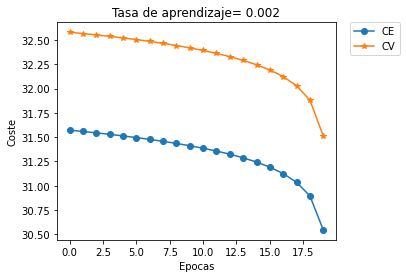

Mejor iteracion es: 1937 con la semilla: 66


In [30]:
dim_capas = [14700, 700, 100, 50, 15, 1]   #  Modelo de 5 capas (Datos de entrada + 4 capas escondidas + capa de salida)

paramL, epoc = modelo_red_L(CE_x, CE_y, CV_x, CV_y, dim_capas, tasa = 0.002, num_iter = 2000, init = "He", semilla = 66, print_c = True) 
   

Identifiquemos el mejor modelo de nuestra red profunda con respecto al numero de epocas:

In [31]:
epoc= 2000
paramL, epoc = modelo_red_L(CE_x, CE_y, CV_x, CV_y, dim_capas, tasa = 0.002, num_iter = epoc, init = "He", semilla = 66, print_c = False) 

C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


Calculemos la exactitud del modelo. Primero definimos nuestra funcion de prediccion `pred()`:

In [32]:
def pred_L(X, param):
      
    m = X.shape[1]
    n = len(param) // 2 
    p = np.zeros((1,m))
    
    probas, memos = propagacion_L(X, param)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
        
    return p

y calculamos la exactitud en entrenamiento y validacion:

In [33]:
pE=pred_L(CE_x, paramL)
pV=pred_L(CV_x, paramL)

n=CE_y.shape[1]
m=CV_y.shape[1]
    
# exactitud 
# entrenamiento
Acc_e = np.sum((pE == CE_y)/n)
    
# validacion
Acc_v = np.sum((pV == CV_y)/m)

print("La exactitud  en entrenamiento es: " +str(Acc_e), " y el de validacion es: " +str(Acc_v))

La exactitud  en entrenamiento es: 0.41714285714285726  y el de validacion es: 0.4266666666666666


Podemos ver que el modelo está aprendiendo hasta sobreajustarse a los datos, pero no generaliza bien de acuerdo con su rendimiento sobre los datos de validación. 

Finalmente probemos nuestro mejor modelo sobre la imagen ``IMG_3451.JPG``. 

In [1]:
import keras
from keras.preprocessing.image import image

#img = image.load_img('IMG_3451.JPG')
#img 

Using TensorFlow backend.


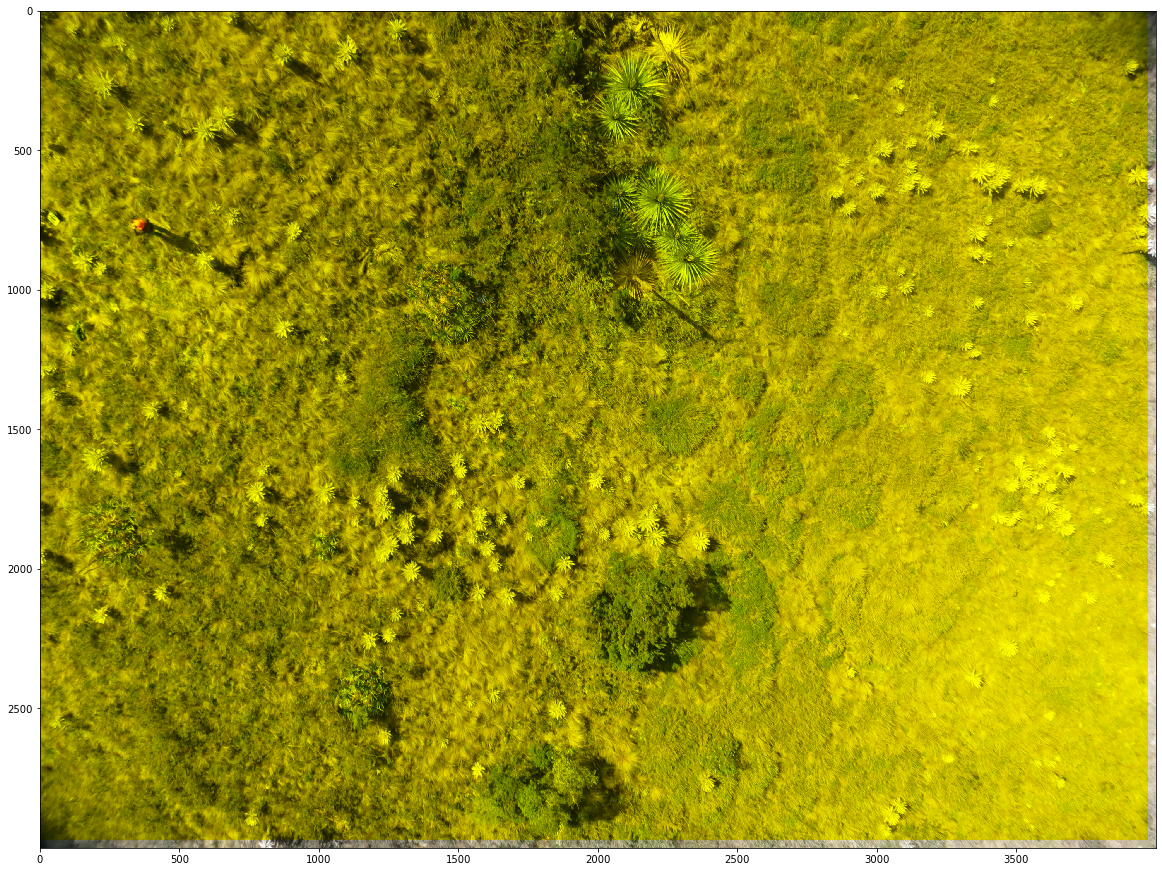

In [35]:
# Lo pasamos por nuestra imagen de prueba
x = np.array(img)
x2 = x

ni = x.shape[0]-50
mi = x.shape[1]-50

f1=0
f2=70
for i in range(1,ni,50):
    c1=0
    c2=70
    for j in range(1,mi,50):
        subi=x[f1:f2,c1:c2,]
        subi2=np.ndarray.flatten(subi).T/255.
        ns=subi2.shape[0]
        vec=subi2
        vec.shape=(ns,1)
        pred_P=pred_L(subi2, paramL)
        if(pred_P==1):
            x2[f1:f2,c1:c2,2]=0
        c1=c1+50
        c2=c2+50
    f1=f1+50
    f2=f2+50
        
plt.figure(figsize = (20,20))
plt.imshow(x2)

Los resultados no parecen mejorar significativamente lo conseguidos por  la red sencilla. A continuacion intente mejorar el modelo. Puede intentar con diferentes arquitecturas, cambiando el método de inicialización, la tasa de aprendizaje, aumentando el número de epocas, entre otras estrategias.

*Ayuda:* Al explorar distintas estrategias, viene bien analizar qué tipo de errores comete el modelo. Primero analicemos el error de manera manual. Revisemos algunas de las imagenes que el modelo de L capas etiquetó incorrectamente. Ejecute la celda abajo para visualizar algunos de estos errores. 

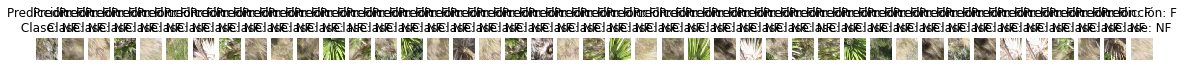

In [36]:
clases = ["NF", "F"]
print_errores(clases, CV_x, CV_y, pV)

**Las distintas imagenes sobre las que el modelo tiende a equivocarse incluyen:** 
- La planta que se concoce como *puya* y se parece al frailejon 
- Pastos borrosos que se confunden con frailejon
- Frailejones con flor y sombras que no se reconocen
- Frailejones borrosos

Antes de enfocarse en el modelo (la arquitectura de la red, el método de incialización, regularización, el algoritmo de optimización, etc.), una buena estrategia previa puede consistir en conseguir más ejemplos sobre ese tipo de imagenes en las que el modelo parece equivocarse. Así se puede conseguir que el modelo aprenda a distinguir acertadamente las clases  que más se le están dificultando. 

#### Mejorando el modelo

Como se observa en el modelo anterior, el modelo no esta aprendiendo dado que los valores inicializados son muy grandes, haciendo que los valores en la función de costo sean muy cercanos a cero, por lo tanto, los valores de gradiente tienden a 0. Una manera de solucionar este problema es modificando el método de inicialización y haciendo que tanto "He" como "Xav" tengan como dimensión el tamaño de entrada a la capa (L-1), al igual que lo hace "rand" y no la cantidad de unidades actual (L). 

In [37]:
def param_I_LN(dim_capas, init, semilla): #inicialización de parámetros
    """
    Input:
    dim_capas: arreglo (lista) de python con las dimensiones de cada capa de la red
    init: método de incialización "rand", "Xav, "He"
    semilla: la semilla aleatoria para la incializacion
    Output:
    param: diccionario python con los parametros "W1", "b1", ..., "WL", "bL":
                    Wl: matriz de pesos (dim_capas[l], dim_capas[l-1])
                    bl: vector de sesgo (dim_capas[l], 1)
    """
    
    np.random.seed( semilla )
    param = {}
    L = len(dim_capas)           

    for l in range(1, L):
        
        if init == "rand":
        # Inicializacion aleatoria
            param['W' + str(l)] = np.random.randn(dim_capas[l], dim_capas[l-1]) * 0.01
            param['b' + str(l)] = np.zeros((dim_capas[l], 1))
        
        # Inicializacion de Xavier
        #Inicializacion de He
        elif init == "Xav":
            param['W' + str(l)] =  np.random.randn(dim_capas[l], dim_capas[l-1]) * np.sqrt(1./dim_capas[l-1])
            param['b' + str(l)] = np.zeros((dim_capas[l], 1))
            
        #Inicializacion de He
        elif init == "He":
            param['W' + str(l)] = np.random.randn(dim_capas[l], dim_capas[l-1]) * np.sqrt(2./dim_capas[l-1])
            param['b' + str(l)] = np.zeros((dim_capas[l], 1))
            
        
        assert(param['W' + str(l)].shape == (dim_capas[l], dim_capas[l-1]))
        assert(param['b' + str(l)].shape == (dim_capas[l], 1))

        
    return param

In [38]:
def modelo_red_LN(X, Y, xV, yV, dim_capas, tasa, num_iter, init, semilla, print_c):
    """
    Implementa una red neuronal de L capas: [LINEAL->RELU]*(L-2)->LINEAL->SIGMOIDE
    Input:
    X: datos de entrada de tamaño (n_x, número de ejemplos)
    Y: vector de etiquetas observadas de tamaño (1, número de ejemplos)
    xV: dataos de entrada de validacion
    yV: etiquetas de validación
    dim_capas: dimensiones de las capas (n_x, n_h, n_y)
    tasa: tasa de aprendizaje de la regla de actualización por GD 
    num_iter: número de iteraciones del bucle de optimización
    init: método de inicializacion de parametros
    semilla: semilla aleatoria para la inciializacion de parametros
    print_c: si es verdadero "True", muestra el coste cada 100 iteraciones 
    Output:
    param: diccionario con los parametros
    """

    costes = []   
    costes2 = [] 
    coste_aux= 99
    epoc=0
    
    # Inicialización de parámetros 
    param = param_I_LN(dim_capas, init, semilla)
    
    # Bucle (GD)
    for i in range(0, num_iter):

        # Propagación hacia delante: [LINEAL -> RELU]*(L-2) -> LINEAL -> SIGMOIDE
        AL, memo = propagacion_L(X, param)
        
        # Calcule el coste
        coste =  perdida_L(AL, Y)
        
        # coste de validacion
        AL2,memo2 = propagacion_L(xV, param)             # propagacion de validacion
        coste2 =  perdida_L(AL2, yV)               # coste de validacion
        
        # Retro-propagación
        grads = retro_L(AL, Y, memo)
 
        # Actualize los parámetros
        param = rev_param(param, grads, tasa)
        
        # Me quedo con la mejor época en validacion
        if coste2 < coste_aux:
            coste_aux=coste2
            epoc = i+1
                
        # Imprime el coste cada 100 iteraciones
        if print_c and i % 100 == 0:
            print ("Coste tras la iteración %i: %f" %(i, coste))
        if print_c and i % 100 == 0:
            costes.append(coste)
            costes2.append(coste2)
            
    # grafique el coste
    if print_c:
        plt.plot(np.squeeze(costes), marker="o", label="CE")
        plt.plot(np.squeeze(costes2), marker="*", label="CV")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.ylabel('Coste')
        plt.xlabel('Epocas')
        plt.title("Tasa de aprendizaje= " + str(tasa))
        #plt.savefig("fig2"+str(i)+".png")
        plt.show()
        print("Mejor iteracion es: " +str(epoc) +" con la semilla: " +str(semilla))
    
    return param, epoc

Coste tras la iteración 0: 0.700524
Coste tras la iteración 100: 0.443472
Coste tras la iteración 200: 0.369409
Coste tras la iteración 300: 0.319353
Coste tras la iteración 400: 0.284562
Coste tras la iteración 500: 0.248026
Coste tras la iteración 600: 0.220094
Coste tras la iteración 700: 0.194517
Coste tras la iteración 800: 0.170932
Coste tras la iteración 900: 0.194298
Coste tras la iteración 1000: 0.080208
Coste tras la iteración 1100: 0.077807
Coste tras la iteración 1200: 0.052773
Coste tras la iteración 1300: 0.043516
Coste tras la iteración 1400: 0.035833
Coste tras la iteración 1500: 0.030305
Coste tras la iteración 1600: 0.025937
Coste tras la iteración 1700: 0.022461
Coste tras la iteración 1800: 0.019665
Coste tras la iteración 1900: 0.017339


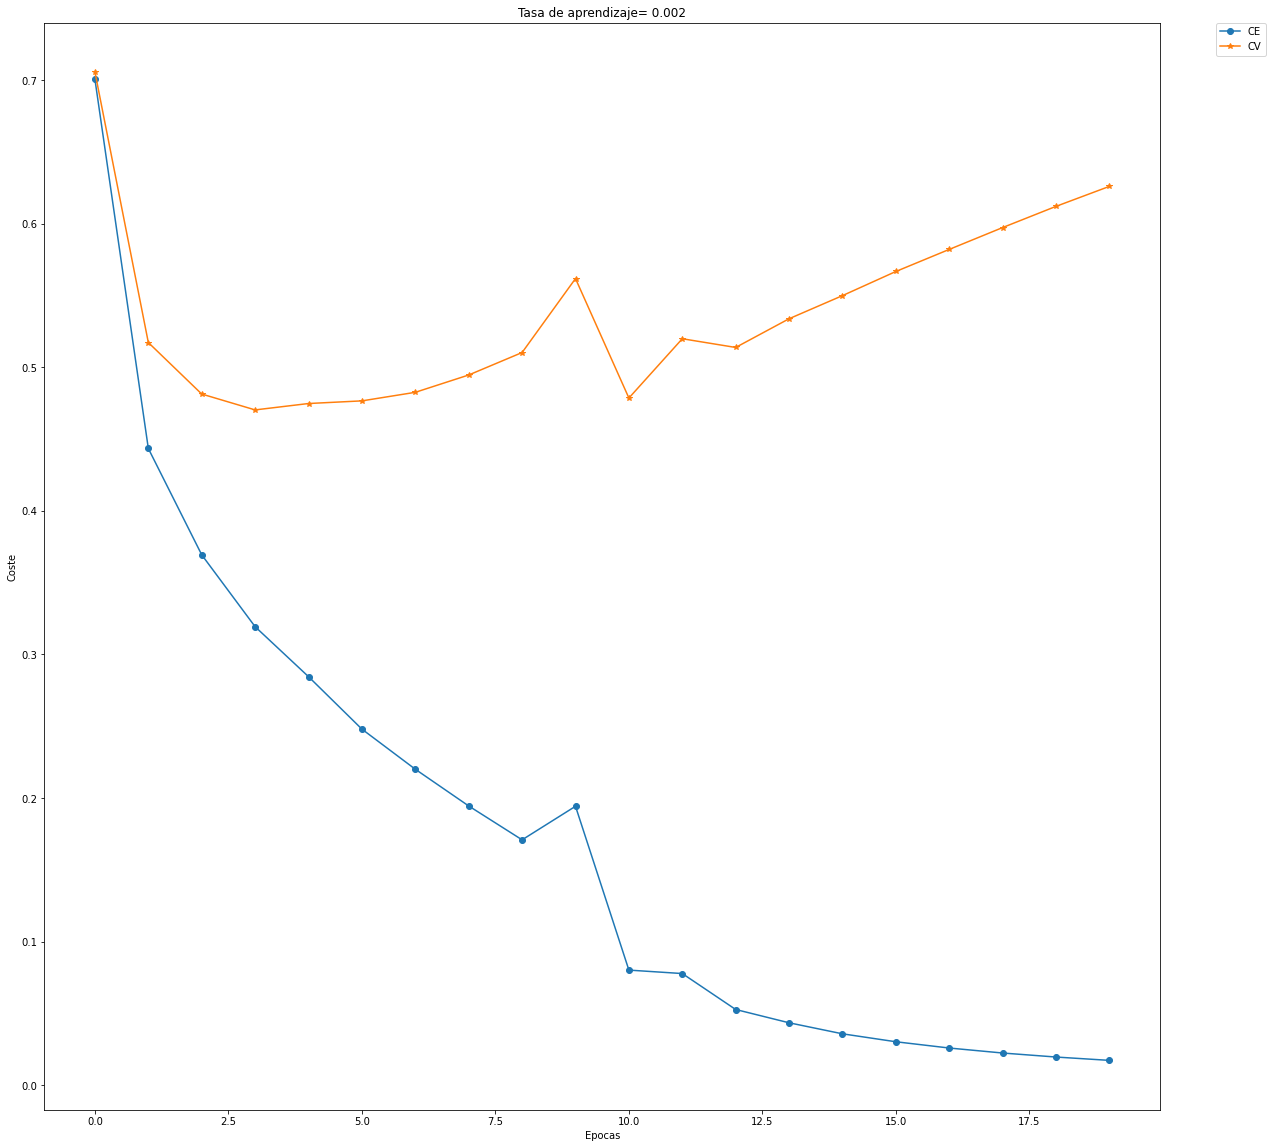

Mejor iteracion es: 315 con la semilla: 66


In [39]:
dim_capas = [14700, 700, 100, 50, 15, 1]   #  Modelo de 5 capas (Datos de entrada + 4 capas escondidas + capa de salida)

paramL, epoc = modelo_red_LN(CE_x, CE_y, CV_x, CV_y, dim_capas, tasa = 0.002, num_iter = 2000, init = "He", semilla = 66, print_c = True) 
   

In [40]:
epoc= 315
paramLN, epoc = modelo_red_LN(CE_x, CE_y, CV_x, CV_y, dim_capas, tasa = 0.002, num_iter = epoc, init = "He", semilla = 66, print_c = False) 

In [41]:
pE=pred_L(CE_x, paramLN)
pV=pred_L(CV_x, paramLN)

n=CE_y.shape[1]
m=CV_y.shape[1]
    
# exactitud 
# entrenamiento
Acc_e = np.sum((pE == CE_y)/n)
    
# validacion
Acc_v = np.sum((pV == CV_y)/m)

print("La exactitud  en entrenamiento es: " +str(Acc_e), " y el de validacion es: " +str(Acc_v))

La exactitud  en entrenamiento es: 0.8800000000000001  y el de validacion es: 0.76


#### Mejorando el modelo

Se realizará la calibración de los hiperparámetros (Épocas y tasa de aprendizaje) para mejorar la precisión del modelo: 

* Épocas: Cantidad de tiempo que se desea que el algortimo entrene todo el conjunto de datos. Se comienza por un número bajo de épocas y luego se aumenta progresivamente, verificando la precisión 

* Tasa de aprendizaje: La importancia de cambiar el peso después de una recalibración. Se debe empezar por 0.1 e irlo educiendo exponencialmente.

Adicionalmente, se cambiara los diferentes métdos de inicialización "He", "Xav", "rand"

In [42]:
init = ["He","rand", "Xav"]
num_iter= [200,500,1000,1500,2000]
tasa = np.arange(0.02,0.1,0.01)
resultados= []
for i in tasa:
    for j in num_iter:
        for k in init: 
            paramLN, epoc = modelo_red_LN(CE_x, CE_y, CV_x, CV_y, dim_capas, tasa = i, num_iter = j, init = k, semilla = 66, print_c = False) 
            pE=pred_L(CE_x, paramLN)
            pV=pred_L(CV_x, paramLN)

            n=CE_y.shape[1]
            m=CV_y.shape[1]

            # exactitud 
            # entrenamiento
            Acc_e = np.sum((pE == CE_y)/n)

            # validacion
            Acc_v = np.sum((pV == CV_y)/m)

            resultados.append([str(k),str(i), str(j), Acc_e, Acc_v])

            #print("La exactitud  en entrenamiento es: " +str(Acc_e), " y el de validacion es: " +str(Acc_v))

C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\USUARIO\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [43]:
import pandas as pd
resultados = pd.DataFrame(resultados, columns=['Inicialización','tasa','iter','acc_entrenamiento','acc_validación'])
resultados

,Inicialización,tasa,iter,acc_entrenamiento,acc_validación
0,He,0.02,200,0.794286,0.720000
1,rand,0.02,200,0.582857,0.573333
2,Xav,0.02,200,0.777143,0.720000
3,He,0.02,500,0.880000,0.786667
4,rand,0.02,500,0.582857,0.573333
...,...,...,...,...,...
115,rand,0.09,1500,0.582857,0.573333
116,Xav,0.09,1500,0.908571,0.773333
117,He,0.09,2000,0.582857,0.573333
118,rand,0.09,2000,0.582857,0.573333


In [50]:
resultados['acc_validación'].max()

0.8533333333333333

In [52]:
maximo = resultados['acc_validación'].max()
in_db = resultados['acc_validación'] == maximo
params_ = resultados[in_db]

##### Mejores hiperpárametros para precisión

In [53]:
params_

,Inicialización,tasa,iter,acc_entrenamiento,acc_validación
6,He,0.02,1000,0.960000,0.853333
8,Xav,0.02,1000,0.954286,0.853333
18,He,0.03,500,0.931429,0.853333
23,Xav,0.03,1000,0.960000,0.853333
